### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.getcwd())

import constants

### Testing the MATH Dataset

In [2]:
from data_classes.MathDataLoader import MathDataLoader
from data_classes.MathProblem import MathProblem
from llm_agents.ChainOfThoughtMathSolver import ChainOfThoughtMathSolver

math_data_loader = MathDataLoader(data_dir=constants.MATH_DATASET_DIR)
# random_problem = math_data_loader.get_random_problem(level=4)
# random_problem = math_data_loader.get_problem(type="algebra", problem_number=265)
random_problem = math_data_loader.get_problem(type="number_theory", problem_number=439)

math_solver = ChainOfThoughtMathSolver()
response = math_solver(random_problem.problem_statement)

print(random_problem)
print(random_problem.problem_statement)
# 
# print(response)

random_problem.is_correct_answer(response, verbose=True)

Loaded 5000 math problems from 7 problem types
MATH problem number 439 of type Number Theory with level 4 and answer \boxed{20}.
If $A$ and $B$ are positive integers, find $A\cdot B$ given that  \[ \begin{array}{c@{}c@{\;}c@{}c@{}c@{}c}& & & A & B_{9}\\ &+& & & A_{9}\\ \cline{2-5}& & & B & 0_{9}\\ \end{array} \] Express your answer in base 10 (you do not need to include the subscript).
Level: 4 | Response: \boxed{20} | Answer: \boxed{20} | Is Correct: True


True

In [9]:
# results = math_data_loader.test_random_problems(math_solver, n_problems=10, level=1, verbose=True)

### Running MACM

In [10]:
import utils
if not os.getenv("OPENAI_API_KEY") or  not os.getenv("TAVILY_API_KEY"):
    os.environ["OPENAI_API_KEY"] = utils.get_openai_api_key()
    os.environ["TAVILY_API_KEY"] = utils.get_tavily_api_key()

In [19]:
run_raw_macm = True

if run_raw_macm:
    sys.path.append(os.path.abspath("MACM/"))

    from MACM.main import main as main_macm

    n = 1 # verification times
    times = 5 # The upper limit of the mining times
    min_voters = 1 # min number of voters
    max_voters = 3 # max number of voters
    problem_statement = random_problem.problem_statement

    main_macm(problem_statement, times, n, min_voters, max_voters, verbose=True)  # Assuming these are defined elsewhere


# 1 Thinker is analyzing the question...

# 1 Conditions: ['\\( A \\) and \\( B \\) are positive integers.', 'Adding \\( AB_9 \\) and \\( A_9 \\) results in \\( B0_9 \\) in base 9 arithmetic.']

# 1 Objectives: ['Calculate the product of \\( A \\) and \\( B \\) in base 10.']

# 1 Thinker is thinking new thoughts...

# 1 Unchecked conditions: ['Based on Known condition 2, which states that adding \\( AB_9 \\) and \\( A_9 \\) results in \\( B0_9 \\) in base 9 arithmetic, we can get: \\( A = \\frac{4}{5}B \\), and \\( B \\) must be a multiple of 5 to ensure both \\( A \\) and \\( B \\) are positive integers.\nReason: By converting the base-9 addition problem into a base-10 equation, we obtained a relationship between \\( A \\) and \\( B \\). Since \\( A \\) and \\( B \\) are integers, \\( B \\) must be divisible by 5. Choosing the smallest integer value for \\( B \\) that satisfies the divisibility condition (i.e., \\( B = 5 \\)), the resultant values for \\( A \\) and \\( B \\) are inte

### LangChain MACM

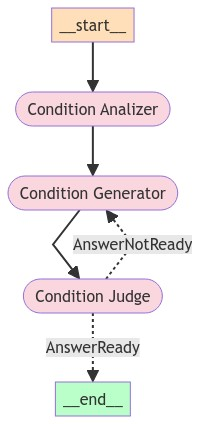

Conditions: 
['1. $A$ and $B$ are positive integers.', '2. The sum of the two numbers with $B$ in base 9 and $A$ in base 10 results in a number with a zero in the units place in base 9.']
Objectives: 
['Find the product of $A$ and $B$ in base 10.']
Event: {'Condition Analizer': {'math_problem': <data_classes.MathProblem.MathProblem object at 0x7fdbaf7b7070>, 'max_iterations': 1, 'verified_conditions': ['1. $A$ and $B$ are positive integers.', '2. The sum of the two numbers with $B$ in base 9 and $A$ in base 10 results in a number with a zero in the units place in base 9.'], 'unverified_conditions': [], 'objectives': ['Find the product of $A$ and $B$ in base 10.'], 'steps': []}}
Summarized condition: Based on the known condition that the sum of the numbers with $B$ in base 9 and $A$ in base 10 results in a number with a zero in the units place in base 9, we can derive the equation $9b + a = 9k$, where $a$ and $b$ are the respective values of $A$ and $B$ in base 10 and base 9, and $k$ is

In [36]:
from multi_agent_graph import get_multi_agent_summarizer_graph
from IPython.display import Image, display


config = {"recursion_limit": 50}
inputs = {
    "math_problem": random_problem,
    "max_iterations": 1,
    "verified_conditions": [],
    "unverified_conditions": [],
    "objectives": [],
    "steps": [],
    "final_answer": None
}

graph = get_multi_agent_summarizer_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

for event in app.stream(inputs, config=config):
    print("Event:", event)